In [169]:
# libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [170]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(79725877)

# Generate sample data
n = 10000

# Continuous variables
living_area = np.random.normal(loc=2000, scale=500, size=n)
num_bedrooms = np.random.poisson(lam=3, size=n)
num_bathrooms = np.random.poisson(lam=2, size=n)
garage_size = np.random.normal(loc=2, scale=1, size=n)
lot_size = np.random.normal(loc=10000, scale=2000, size=n)
year_built = np.random.normal(loc=1995, scale=20, size=n)

# Discrete variables
house_style = np.random.choice(["Ranch", "Colonial", "Split-Level"], n)
neighborhood = np.random.choice(["Suburban", "Urban"], n)
school_district = np.random.choice(["Good", "Average", "Poor"], n)

# Interactions
living_area_neighborhood = living_area + np.where(neighborhood == "Urban", -500, 500)
living_area_garage = living_area * garage_size
num_bedrooms_bathrooms = num_bedrooms * num_bathrooms

# Generate response variable
house_prices = abs(100000 + (2000 * num_bedrooms + 3000 * num_bathrooms +
                             10000 * garage_size + 10 * lot_size +
                             500 * (year_built - 1995) ** 2 +
                             5000 * np.where(house_style == "Colonial", 1, 0) +
                             5000 * np.where(house_style == "Split-Level", -1, 0) +
                             10000 * np.where(neighborhood == "Urban", -1, 0) +
                             5000 * np.where(school_district == "Good", 1, -1) +
                             0.01 * living_area_neighborhood + 0.02 * living_area_garage +
                             1000 * num_bedrooms_bathrooms +
                             10 * num_bedrooms_bathrooms ** 2 +
                             np.where(house_style == "Split-Level", -1, 0) * living_area +
                             1000 * (year_built - 1995) ** 2 * num_bedrooms_bathrooms ** 3) / living_area +
                   np.random.normal(loc=0, scale=10000, size=n))

# Create dataframe
house_data = pd.DataFrame({'house_prices': house_prices,
                           'living_area': living_area,
                           'num_bedrooms': num_bedrooms,
                           'num_bathrooms': num_bathrooms,
                           'garage_size': garage_size,
                           'lot_size': lot_size,
                           'year_built': year_built,
                           'house_style': house_style,
                           'neighborhood': neighborhood,
                           'school_district': school_district})

# Print the first 10 rows
print(house_data.head(10))

# Summary
print(house_data.describe())


    house_prices  living_area  num_bedrooms  num_bathrooms  garage_size  \
0  104650.106324  2750.504829             3              0     3.291452   
1  110324.228237  2314.820268             6              1     4.261236   
2   98600.930281  3066.930023             4              2     2.894254   
3   99190.163277  2683.340720             1              5     4.162642   
4  116311.643044  2727.317303             3              2     2.682986   
5   89500.579184  2729.527287             3              0     0.542204   
6  106708.417941   991.579229             2              4     2.067132   
7  102137.454840  2710.881596             5              1     2.593453   
8  100776.398622  2195.903843             5              2     1.963957   
9  111436.088692  2351.727801             3              1     1.745720   

       lot_size   year_built  house_style neighborhood school_district  
0  10367.206797  2000.068980  Split-Level        Urban         Average  
1  12753.614128  1991.460825

## 1. Outliers

There are several ways to identify outliers, and they vary by their flexibility and explainability. Rather than just looking at numerical discriptions of the data alone, it might be easier to first graph the distributions of the quantitative variables of the data.

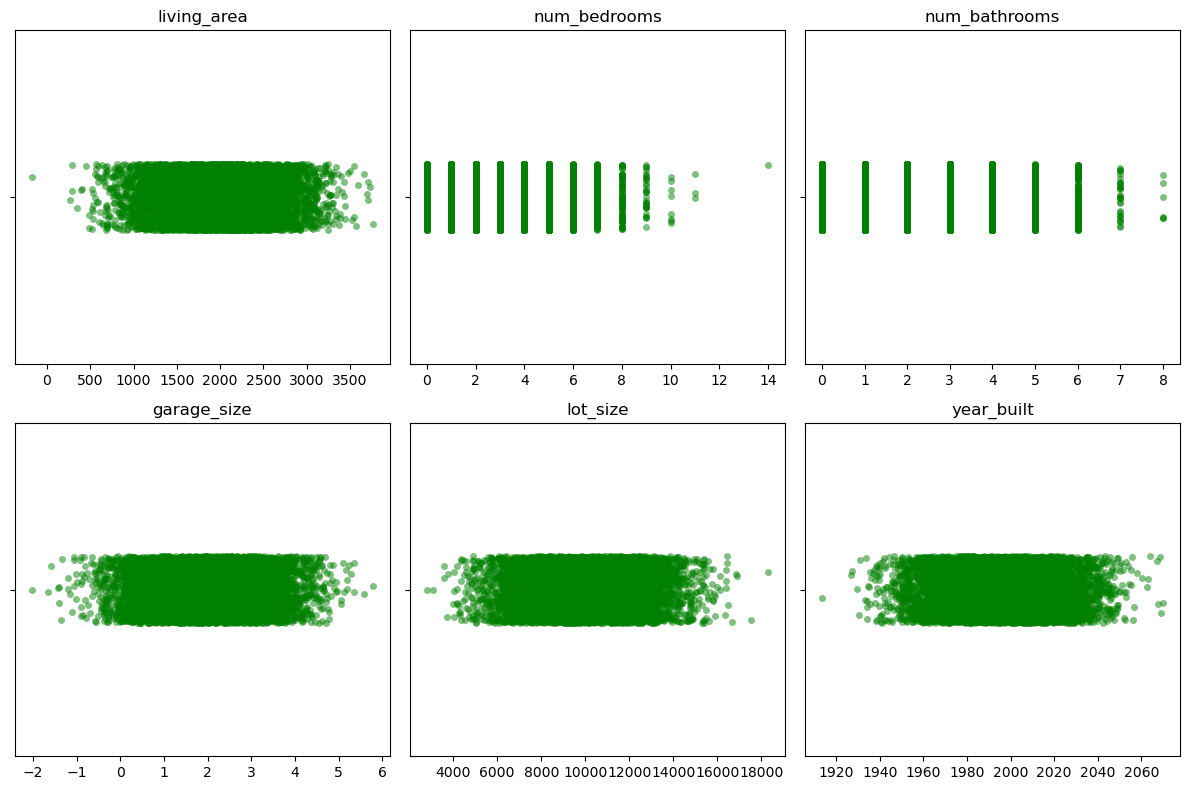

In [171]:
plt.figure(figsize=(12, 8))
numerical_features = ['living_area', 'num_bedrooms', 'num_bathrooms', 'garage_size', 'lot_size', 'year_built']

# Iterate over numerical features
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.stripplot(x=feature, data=house_data, jitter=True, marker='o', alpha=0.5, color='green')
    plt.title(feature)
    plt.xlabel('')

plt.tight_layout()
plt.show()

Since Box Plots don't tell the whole story, we decide to use dot plots of each explanatory variable to get a better idea of what the distributions look like for each variable. We see that outliers can range from deviation alone as well as non-sensical values. For example, it does not make sense for garage_size to be in the negatives, or for living_area to have a negative value. We will drop these values from the dataset then proceed with the standardized residual plots.

In [172]:
house_data_clean = house_data.copy()  # Create a copy of the original dataframe for cleaning

# remove negative living area values
house_data_clean = house_data_clean[house_data_clean['living_area'] > 0]

# remove nonsensical garage size values
house_data_clean = house_data_clean[(house_data_clean['garage_size'] >= 0)] 

In practice, it can be difficult to appropriately identify how a large a residual needs to be before we can consider a point to be an outlier. Therefore, instead of plotting the residuals, we will plot the studentized residuals. The studentized residuals whose' value exceeds an absolute value of 3 will be considered potential outliers. 

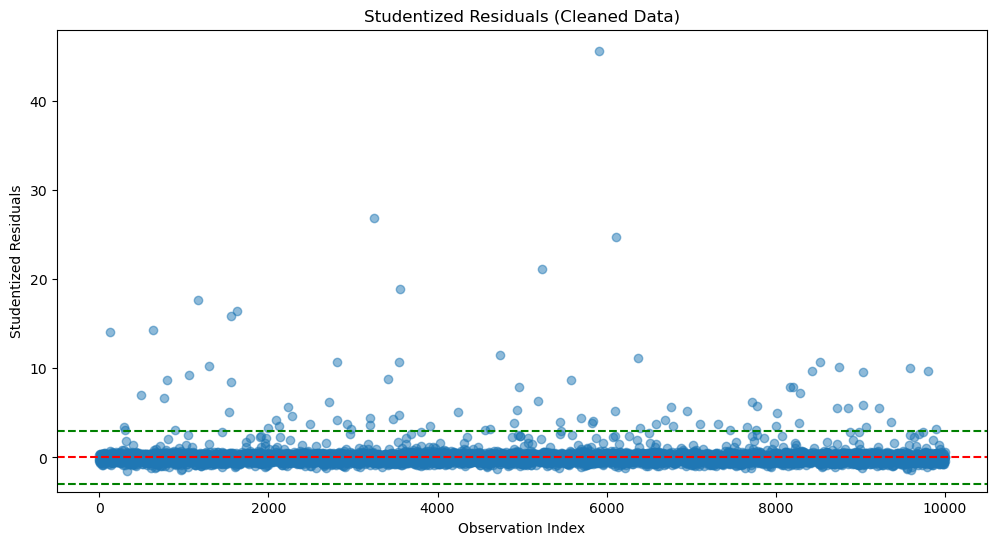

In [173]:
import statsmodels.api as sm

explanatory_vars = ['living_area', 'num_bedrooms', 'num_bathrooms', 'garage_size', 'lot_size', 'year_built']
model_cleaned = sm.OLS(house_data_clean['house_prices'], sm.add_constant(house_data_clean[explanatory_vars]))
results_cleaned = model_cleaned.fit()

# calculate residuals for cleaned data
residuals_cleaned = results_cleaned.resid

# calculate studentized residuals for cleaned data
studentized_residuals_cleaned = results_cleaned.get_influence().resid_studentized_internal

# plot studentized residuals for cleaned data
plt.figure(figsize=(12, 6))
plt.scatter(house_data_clean.index, studentized_residuals_cleaned, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='g', linestyle='--')
plt.axhline(y=-3, color='g', linestyle='--')
plt.title('Studentized Residuals (Cleaned Data)')
plt.xlabel('Observation Index')
plt.ylabel('Studentized Residuals')
plt.show()

In [174]:
# removing the studentized residuals above absolute value 3 from the dataset
cleaned_A_indices = np.abs(studentized_residuals_cleaned) <= 3
house_data_clean_A = house_data_clean[cleaned_A_indices]

model_cleaned_A = sm.OLS(house_data_clean_A['house_prices'], sm.add_constant(house_data_clean_A[explanatory_vars]))
results_cleaned_A = model_cleaned_A.fit()

model_cleaned_B = sm.OLS(house_data_clean['house_prices'], sm.add_constant(house_data_clean[explanatory_vars]))
results_cleaned_B = model_cleaned_B.fit()

# compare R-squared values
print("R-squared (cleaned_A):", results_cleaned_A.rsquared)
print("R-squared (cleaned_B):", results_cleaned_B.rsquared)

# compare Residual Standard Error (RSE)
print("RSE (cleaned_A):", np.sqrt(results_cleaned_A.mse_resid))
print("RSE (cleaned_B):", np.sqrt(results_cleaned_B.mse_resid))

R-squared (cleaned_A): 0.22034069432249914
R-squared (cleaned_B): 0.12764713395635574
RSE (cleaned_A): 481740.57527640974
RSE (cleaned_B): 1522236.3247993554


We see that removing the possible outliers with studentized residuals greater than 3 in absolute values increases our R^2 as well as decreases our RSE quite significantly. Therefore, we will proceed with using the cleaned data that does not include the possible outliers. 

## 2. Dimensionality Reduction

There are many dimensionality reduction techniques, but here we will apply principal component analysis (PCA).

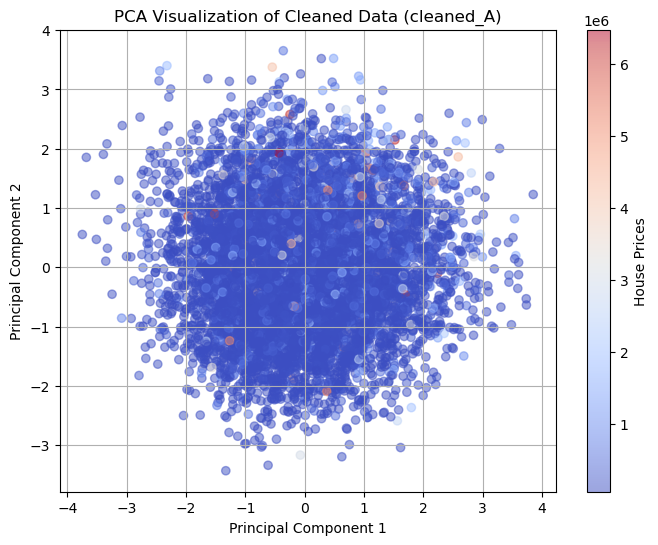

In [175]:
from sklearn.decomposition import PCA
features = house_data_clean_A.drop(columns=['house_prices', 'house_style', 'neighborhood', 'school_district'])

# standardizing
features_standardized = (features - features.mean()) / features.std()

# performing PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_standardized)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=house_data_clean_A['house_prices'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Cleaned Data (cleaned_A)')
plt.colorbar(label='House Prices')
plt.grid(True)
plt.show()

C:\Users\Connor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


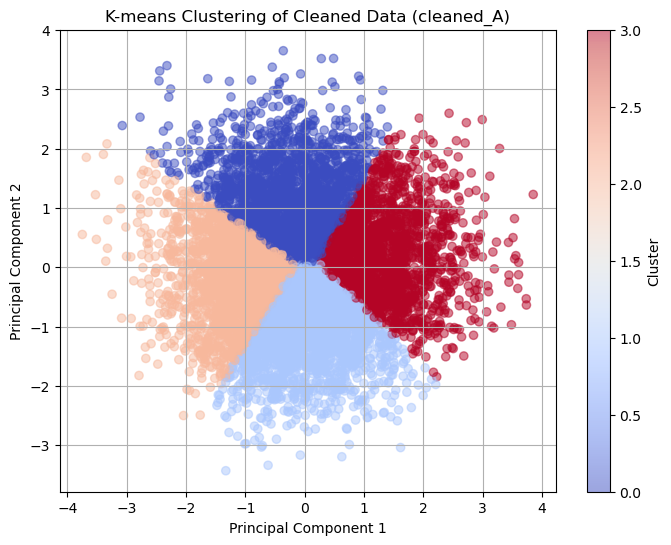

In [176]:
from sklearn.cluster import KMeans

# using K-means clustering with 4 clusters to find clusters within the data
kmeans = KMeans(n_clusters=4, random_state=79725877)
cluster_labels = kmeans.fit_predict(pca_result)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Cleaned Data (cleaned_A)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

We can use K-means clustering to identify any clusters in the data. With dimensionality reduction and K-means clustering, we see that the data may not have distinct clusters, evidenced by the circle and its 4 effectively equal slices. The data points are equally spread and clustered around the zero point. 

## 3. Classification

There are many classification methods at our disposal to estimate if a house is in an urban or suburban neighborhood based on its features. For this scenario, we will employ gradient boosting. 

Accuracy (Urban): 0.6123949579831933
Accuracy (Suburban): 0.3917004048582996
Overall Accuracy: 0.5
                    Feature  Importance
6              house_prices    0.214512
3               garage_size    0.183218
0               living_area    0.178550
5                year_built    0.167409
4                  lot_size    0.132074
1              num_bedrooms    0.060537
2             num_bathrooms    0.032078
9   house_style_Split-Level    0.010785
12     school_district_Poor    0.009903
10  school_district_Average    0.006876


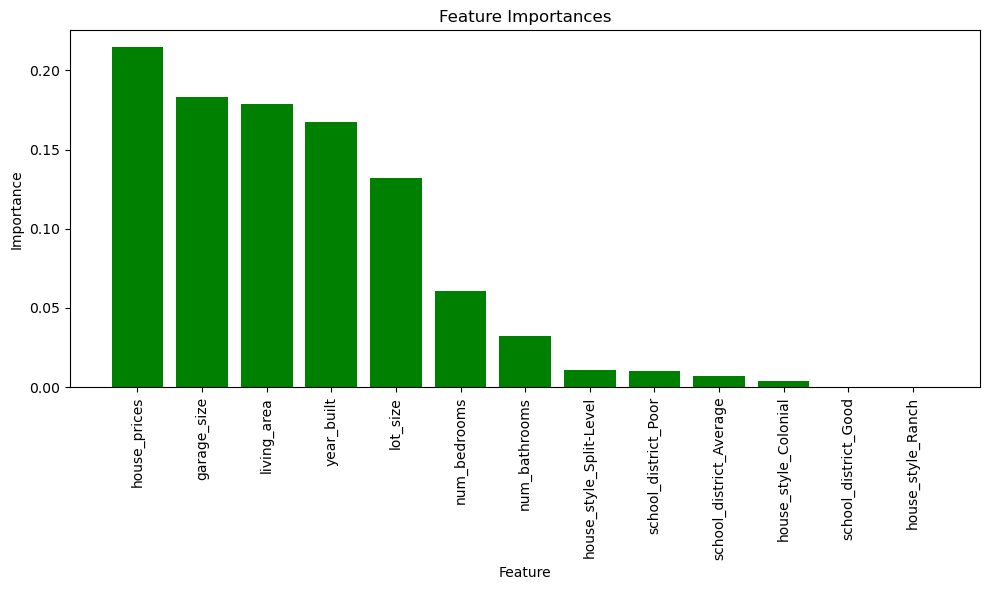

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# determining target variable
X = house_data_clean_A.drop(columns=['neighborhood'])  
y = house_data_clean_A['neighborhood']  

# splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79725877)

# setting the explanatory variables
categorical_features = ['house_style', 'school_district']
numerical_features = ['living_area', 'num_bedrooms', 'num_bathrooms', 'garage_size', 'lot_size', 'year_built', 'house_prices']

numerical_transformer = 'passthrough'
# transforming the categorical variables
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())  
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Urban accuracy
accuracy_urban = accuracy_score(y_test[y_test == 'Urban'], y_pred[y_test == 'Urban'])

# Suburban accuracy
accuracy_suburban = accuracy_score(y_test[y_test == 'Suburban'], y_pred[y_test == 'Suburban'])

print("Accuracy (Urban):", accuracy_urban)
print("Accuracy (Suburban):", accuracy_suburban)

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Feature importance
feature_importance = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
importance_df = pd.DataFrame({'Feature': numerical_features + list(feature_names), 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Top 10 features
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Above we see the relative "importance" of each predictor with regard to classifying an observation as residing in an urban or suburban neighborhood. According to the output above, house price and garage size tens to have the greatest importance in classifying the neighborhood of a house as urban or suburban. We cannot, however, interpret these variables as causal. For example, while a larger garage size might be highly correlated with houses in suburban neighborhoods, it does not necessarily cause the house to be in a suburban neighborhood. The same logic applies to lot size, the year the house was built, and so on. Additionally, other variables like such as median house income, which could be correlated with a number of these predictors, are omitted from the model. 

## 4. Random Forest Prediction

In [178]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

We know that the feature importance in the random forest model for house price predictions will vary quite differently from the feature importance we saw in the classification problem with gradient boosting. With random forests, we see that the year the house was built as well as the number of bedrooms and number of bathrooms easily are the most important variables with regard to house prices. However, to avoid overfitting, we should also employ techniques like pruning and cross-validation. We limit the depth of the trees to 5, set the number of trees to 100, and perform 5-fold cross-validation and subsequently calculate the R^2 scores for each of those folds. It should be noted that increasing the number of trees will dramatically increase the computation time. Other techniques to address overfitting could be omitting the otherwise irrelevant features and using Lasso.

Cross-validated R-squared scores: [0.87656378 0.87306388 0.85404932 0.83881672 0.85458556]
Mean R-squared: 0.8594158518189173
                    Feature  Importance
5                year_built    0.414494
1              num_bedrooms    0.274559
2             num_bathrooms    0.222060
0               living_area    0.038548
4                  lot_size    0.019082
3               garage_size    0.014226
8   house_style_Split-Level    0.002753
11  school_district_Average    0.002385
13     school_district_Poor    0.002133
9     neighborhood_Suburban    0.002109


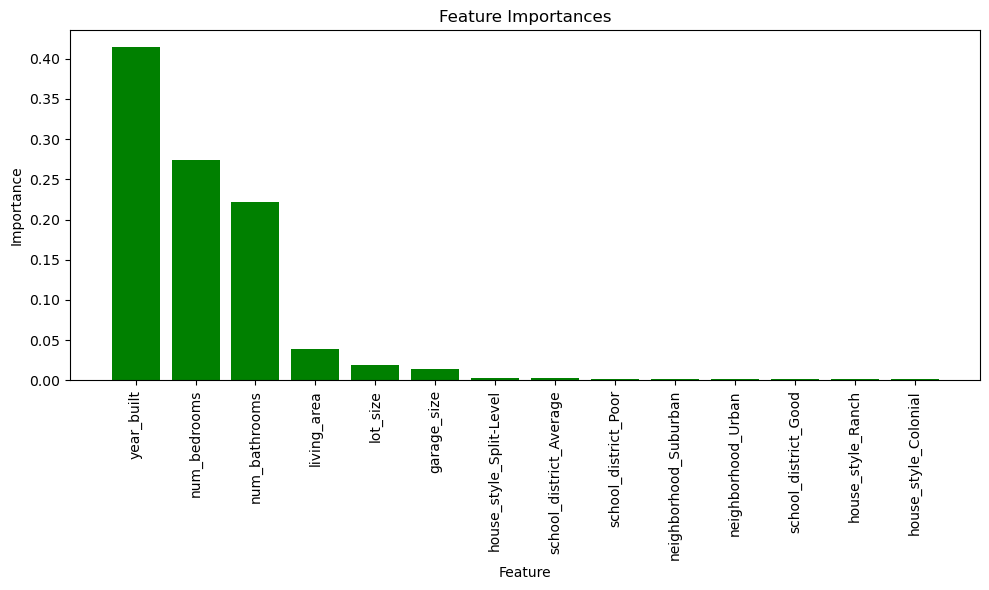

In [179]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

# determining the target variable
X = house_data_clean_A.drop(columns=['house_prices'])
y = house_data_clean_A['house_prices']

# setting the explanatory variables
categorical_features = ['house_style', 'neighborhood', 'school_district']
numerical_features = ['living_area', 'num_bedrooms', 'num_bathrooms', 'garage_size', 'lot_size', 'year_built']

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())  
])
# pipeline to allows us to fit random forest to the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=79725877))  
    # Random forest regressor with 100 trees and maximum depth of 10
])

# cross validation with 5 folds
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared:", cv_scores.mean())

model.fit(X, y)

# feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# creating a list of all the feature names
categorical_feature_names = model.named_steps['preprocessor'].named_transformers_['cat']['onehot']\
                            .get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(categorical_feature_names)

importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


As expected, variables like garage_size are no longer the most important when prediciting house prices as compared to classifying houses as urban or suburban. With so many features not as important as the features like year_built and num_bedrooms, excluding them in the feature could be a possibility. 